In [1]:
import os
import csv
import random

# Просто список путей до корней доменов
DATASET_DIRS = [
    'CUB_200_2011_split',
    'dtd_split',
    'fungi_clef_2022_split'
]

rows = []

for domain_path in DATASET_DIRS:
    domain = os.path.basename(domain_path.rstrip('/\\'))
    # Проходим по всем подпапкам - это и есть splits (train, val, test)
    for split in os.listdir(domain_path):
        split_path = os.path.join(domain_path, split)
        if not os.path.isdir(split_path):
            continue
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if not os.path.isdir(class_path):
                continue
            for filename in os.listdir(class_path):
                if not filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.webp')):
                    continue
                image_path = os.path.abspath(os.path.join(class_path, filename))
                rows.append({
                    'image_path': image_path,
                    'class_name': class_name,
                    'domain': domain,
                    'split': split
                })

# Перемешиваем все строки (shuffle классов и изображений)
random.shuffle(rows)

# Итоговый CSV
csv_path = 'merged_dataset_v2.csv'
with open(csv_path, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=['image_path', 'class_name', 'domain', 'split'])
    writer.writeheader()
    writer.writerows(rows)

print(f'CSV сохранён: {csv_path}')
print(f'Всего строк: {len(rows)}')
print('Пример первой строки:', rows[0] if rows else 'Нет данных')

CSV сохранён: merged_dataset_v2.csv
Всего строк: 56902
Пример первой строки: {'image_path': 'd:\\Магистратура\\ВКР\\CUB_200_2011_split\\train\\006.Least_Auklet\\Least_Auklet_0030_795116.jpg', 'class_name': '006.Least_Auklet', 'domain': 'CUB_200_2011_split', 'split': 'train'}


In [1]:
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

train_transform = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=10, p=0.2),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

# Для валидации/теста (только resize + norm)
val_transform = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

class CsvImageDataset(Dataset):
    def __init__(self, csv_path, split, transform=None, class_names=None):
        df = pd.read_csv(csv_path)
        self.df = df[df['split'] == split].reset_index(drop=True)
        self.transform = transform

        if class_names is None:
            self.class_names = sorted(self.df['class_name'].unique())
        else:
            self.class_names = class_names

        self.class_to_idx = {cls: i for i, cls in enumerate(self.class_names)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = np.array(Image.open(row['image_path']).convert('RGB'))
        if self.transform:
            image = self.transform(image=image)['image']
        label = self.class_to_idx[row['class_name']]
        return image, label

d:\Магистратура\ВКР\.venv\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
import torch
import open_clip
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

# === Конфиги ===
CSV_PATH = 'merged_dataset_v2.csv'
BATCH_SIZE = 32
NUM_WORKERS = 0
NUM_EPOCHS = 10
LR = 1e-5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_NAME = 'ViT-B-32'
PRETRAINED = 'laion2b_s34b_b79k'
CHECKPOINT_PATH = 'finetuned_openclip_v1.pth'

SPLITS = ['train', 'val', 'test', 'обучение', 'валидация', 'тест']  # можно адаптировать под свой CSV

# === 1. Инициализация трансформаций ===
_, _, preprocess = open_clip.create_model_and_transforms(MODEL_NAME, pretrained=PRETRAINED)

# === 2. Загрузка датасетов ===
# Пример: если train и val на русском - замени 'train' на 'обучение', 'val' на 'валидация'
train_dataset = CsvImageDataset(CSV_PATH, split='train', transform=train_transform)
val_dataset   = CsvImageDataset(CSV_PATH, split='val',   transform=val_transform)



df = pd.read_csv(CSV_PATH)
all_classes = set(df[df['split'] == 'train']['class_name'].unique())
# Если у тебя split называется по-другому, замени 'train' на 'обучение'
# И аналогично для 'val', если это 'валидация'
train_dataset = CsvImageDataset(CSV_PATH, split='train', transform=train_transform, class_names=all_classes)
val_dataset = CsvImageDataset(CSV_PATH, split='val', transform=val_transform, class_names=all_classes)

idx_to_class = {i: c for i, c in enumerate(all_classes)}

train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader    = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


class_names = train_dataset.class_names
print(f'Классов: {len(class_names)}')
print('Пример классов:', class_names[:10])

train_classes = set(df[df['split'] == 'train']['class_name'].unique())
val_classes = set(df[df['split'] == 'val']['class_name'].unique())
unseen_classes = val_classes - train_classes
seen_classes = train_classes & val_classes

model, _, _ = open_clip.create_model_and_transforms(MODEL_NAME, pretrained=PRETRAINED)
model = model.to(DEVICE)


val_class_names = val_dataset.class_names

tokenizer = open_clip.get_tokenizer(MODEL_NAME)
prompts = [f"{c}" for c in class_names]
with torch.no_grad():
    text_tokens = tokenizer(prompts).to(DEVICE)
    text_features = model.encode_text(text_tokens)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)



# === 5. Разморозка визуального энкодера (можно дообучать и текстовый по желанию) ===
for p in model.parameters():
    p.requires_grad = False
for p in model.visual.parameters():
    p.requires_grad = True

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
loss_fn = torch.nn.CrossEntropyLoss()


Классов: 279


TypeError: 'set' object is not subscriptable

In [2]:
import matplotlib.pyplot as plt

train_losses = []
val_accuracies = []
val_f1s = []
gzsl_seen_accs = []
gzsl_unseen_accs = []
gzsl_hmeans = []


def compute_gzsl(trues_cls, preds_cls, seen_classes, unseen_classes):
    seen_mask = [cls in seen_classes for cls in trues_cls]
    unseen_mask = [cls in unseen_classes for cls in trues_cls]
    seen_acc = sum([t == p for t, p, m in zip(
        trues_cls, preds_cls, seen_mask) if m]) / max(sum(seen_mask), 1)
    unseen_acc = sum([t == p for t, p, m in zip(trues_cls, preds_cls, unseen_mask) if m]) / max(sum(unseen_mask), 1)
    h_mean = 2 * seen_acc * unseen_acc / (seen_acc + unseen_acc) if (seen_acc + unseen_acc) > 0 else 0.0
    return seen_acc, unseen_acc, h_mean

In [4]:
from time import time


val_class_names = val_dataset.class_names  # это все классы, включая unseen
idx_to_class = {i: c for i, c in enumerate(val_class_names)}

def train_one_epoch(epoch):
    model.train()
    total_loss = 0
    pbar = tqdm(train_loader, desc=f"Эпоха {epoch+1}")
    for images, labels in pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        image_features = model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        logits = 100. * image_features @ text_features.T
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"[Эпоха {epoch+1}] Train loss: {avg_loss:.4f}")
    return avg_loss


def validate():
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Валидация'):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            image_features = model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

            logits = 100. * image_features @ text_features.T
            pred = logits.argmax(dim=1).cpu().tolist()
            preds.extend(pred)
            trues.extend(labels.cpu().tolist())

    # Преобразование в имена классов
    trues_cls = [idx_to_class[i] for i in trues]
    preds_cls = [idx_to_class[i] for i in preds]

    # GZSL
    seen_acc, unseen_acc, h_mean = compute_gzsl(trues_cls, preds_cls, seen_classes, unseen_classes)
    print(f"[GZSL] Seen acc: {seen_acc:.4f} | Unseen acc: {unseen_acc:.4f} | H-mean: {h_mean:.4f}")
    gzsl_seen_accs.append(seen_acc)
    gzsl_unseen_accs.append(unseen_acc)
    gzsl_hmeans.append(h_mean)

    # Accuracy & F1
    acc = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds, average='macro')
    val_accuracies.append(acc)
    val_f1s.append(f1)

    print(f"[Валидация] Top-1 Accuracy: {acc:.4f}, Macro F1: {f1:.4f}")
    return acc, f1, seen_acc, unseen_acc, h_mean


# === Основной цикл обучения ===
for epoch in range(NUM_EPOCHS):
    start_time = time()
    train_loss = train_one_epoch(epoch)
    train_losses.append(train_loss)
    acc, f1, seen_acc, unseen_acc, hmean = validate()
    epoch_time = time() - start_time
    print(f"[Время] Эпоха {epoch+1} завершена за {epoch_time:.1f} сек")

    # Сохраняем модель каждые 10 эпох
    if (epoch + 1) % 10 == 0:
        checkpoint_path = f"{CHECKPOINT_PATH}_epoch{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Сохранён чекпоинт: {checkpoint_path}")

# Финальное сохранение модели
torch.save(model.state_dict(), CHECKPOINT_PATH)
print("Обучение завершено. Модель сохранена.")


Эпоха 1: 100%|██████████| 799/799 [01:51<00:00,  7.20it/s]


[Эпоха 1] Train loss: 1.9150


Валидация: 100%|██████████| 431/431 [00:34<00:00, 12.64it/s]


[GZSL] Seen acc: 0.0022 | Unseen acc: 0.0052 | H-mean: 0.0031
[Валидация] Top-1 Accuracy: 0.0041, Macro F1: 0.0020
[Время] Эпоха 1 завершена за 145.2 сек


Эпоха 2: 100%|██████████| 799/799 [01:53<00:00,  7.07it/s]


[Эпоха 2] Train loss: 0.8796


Валидация:  39%|███▊      | 166/431 [00:14<00:22, 11.81it/s]


KeyboardInterrupt: 

In [3]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.plot(epochs, val_f1s, label='Val Macro F1')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Validation Metrics')
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig('metrics_plot.png')
plt.show()

In [4]:
# model.train()
# total_loss = 0
# for images, labels in tqdm(train_loader, desc=f"Эпоха {0}"):
#     images, labels = images.to(DEVICE), labels.to(DEVICE)
#     #print(images, labels)
#     with torch.no_grad():
#         text_features = model.encode_text(text_tokens)
#         text_features = text_features / text_features.norm(dim=-1, keepdim=True)
#     image_features = model.encode_image(images)
#     image_features = image_features / image_features.norm(dim=-1, keepdim=True)
#     logits = 100. * image_features @ text_features.T
#     loss = loss_fn(logits, labels)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     total_loss += loss.item()
# print(f"Train loss: {total_loss/len(train_loader):.4f}")

In [5]:
# model.eval()
# preds, trues = [], []
# with torch.no_grad():
#     for images, labels in val_loader:
#         images = images.to(DEVICE)
#         text_features = model.encode_text(text_tokens)
#         text_features = text_features / text_features.norm(dim=-1, keepdim=True)
#         image_features = model.encode_image(images)
#         image_features = image_features / image_features.norm(dim=-1, keepdim=True)
#         logits = 100. * image_features @ text_features.T
#         pred = logits.argmax(dim=1).cpu().numpy()
#         preds.extend(pred)
#         trues.extend(labels.cpu().numpy())
# acc = accuracy_score(trues, preds)
# macro_f1 = f1_score(trues, preds, average='macro')

In [7]:
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Эпоха {epoch+1}"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        with torch.no_grad():
            text_features = model.encode_text(text_tokens)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        image_features = model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        logits = 100. * image_features @ text_features.T
        loss = loss_fn(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Train loss: {avg_train_loss:.4f}")

    # === Валидация ===
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            text_features = model.encode_text(text_tokens)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            image_features = model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            logits = 100. * image_features @ text_features.T
            pred = logits.argmax(dim=1).cpu().numpy()
            preds.extend(pred)
            trues.extend(labels.cpu().numpy())

    idx_to_class = {i: c for i, c in enumerate(class_names)}
    trues_cls = [idx_to_class[i] for i in trues]
    preds_cls = [idx_to_class[i] for i in preds]
    seen_acc, unseen_acc, h_mean = compute_gzsl(trues_cls, preds_cls, seen_classes, unseen_classes)
    print(f"[GZSL] Seen acc: {seen_acc:.4f} | Unseen acc: {unseen_acc:.4f} | H-mean: {h_mean:.4f}")
    gzsl_seen_accs.append(seen_acc)
    gzsl_unseen_accs.append(unseen_acc)
    gzsl_hmeans.append(h_mean)



    acc = accuracy_score(trues, preds)
    macro_f1 = f1_score(trues, preds, average='macro')
    val_accuracies.append(acc)
    val_f1s.append(macro_f1)
    
    print(f"[Валидация] Top-1 Accuracy: {acc:.4f}, Macro F1: {macro_f1:.4f}")
    if (epoch + 1) % 10 == 0:
        checkpoint_path = f"{CHECKPOINT_PATH}_epoch{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Сохранён чекпоинт: {checkpoint_path}")

# Итоговое сохранение
torch.save(model.state_dict(), CHECKPOINT_PATH)
print("Обучение завершено. Модель сохранена.")

Эпоха 1: 100%|██████████| 799/799 [04:42<00:00,  2.83it/s]


Train loss: 2.1190
[GZSL] Seen acc: 0.7671 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.5147, Macro F1: 0.4998


Эпоха 2: 100%|██████████| 799/799 [04:02<00:00,  3.30it/s]


Train loss: 1.1502
[GZSL] Seen acc: 0.8243 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.5530, Macro F1: 0.5583


Эпоха 3: 100%|██████████| 799/799 [03:56<00:00,  3.38it/s]


Train loss: 0.8047
[GZSL] Seen acc: 0.8814 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.5914, Macro F1: 0.6030


Эпоха 4: 100%|██████████| 799/799 [03:55<00:00,  3.39it/s]


Train loss: 0.5860
[GZSL] Seen acc: 0.9061 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6080, Macro F1: 0.6033


Эпоха 5: 100%|██████████| 799/799 [03:55<00:00,  3.39it/s]


Train loss: 0.4423
[GZSL] Seen acc: 0.9210 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6179, Macro F1: 0.6368


Эпоха 6: 100%|██████████| 799/799 [03:55<00:00,  3.39it/s]


Train loss: 0.3421
[GZSL] Seen acc: 0.9450 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6340, Macro F1: 0.6534


Эпоха 7: 100%|██████████| 799/799 [03:56<00:00,  3.38it/s]


Train loss: 0.2968
[GZSL] Seen acc: 0.9633 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6463, Macro F1: 0.6593


Эпоха 8: 100%|██████████| 799/799 [03:50<00:00,  3.47it/s]


Train loss: 0.2377
[GZSL] Seen acc: 0.9612 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6449, Macro F1: 0.6613


Эпоха 9: 100%|██████████| 799/799 [03:49<00:00,  3.49it/s]


Train loss: 0.2198
[GZSL] Seen acc: 0.9626 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6458, Macro F1: 0.6655


Эпоха 10: 100%|██████████| 799/799 [03:48<00:00,  3.49it/s]


Train loss: 0.1897
[GZSL] Seen acc: 0.9478 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6359, Macro F1: 0.6522
Сохранён чекпоинт: finetuned_openclip_csv.pth_epoch10.pth


Эпоха 11: 100%|██████████| 799/799 [03:48<00:00,  3.50it/s]


Train loss: 0.1554
[GZSL] Seen acc: 0.9887 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6634, Macro F1: 0.6837


Эпоха 12: 100%|██████████| 799/799 [03:48<00:00,  3.50it/s]


Train loss: 0.1521
[GZSL] Seen acc: 0.9859 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6615, Macro F1: 0.6817


Эпоха 13: 100%|██████████| 799/799 [03:48<00:00,  3.50it/s]


Train loss: 0.1446
[GZSL] Seen acc: 0.9809 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6581, Macro F1: 0.6748


Эпоха 14: 100%|██████████| 799/799 [03:48<00:00,  3.50it/s]


Train loss: 0.1259
[GZSL] Seen acc: 0.9845 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6605, Macro F1: 0.6807


Эпоха 15: 100%|██████████| 799/799 [03:48<00:00,  3.50it/s]


Train loss: 0.1412
[GZSL] Seen acc: 0.9852 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6610, Macro F1: 0.6708


Эпоха 16: 100%|██████████| 799/799 [04:03<00:00,  3.28it/s]


Train loss: 0.1129
[GZSL] Seen acc: 0.9866 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6619, Macro F1: 0.6823


Эпоха 17: 100%|██████████| 799/799 [04:01<00:00,  3.31it/s]


Train loss: 0.1111
[GZSL] Seen acc: 0.9845 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6605, Macro F1: 0.6808


Эпоха 18: 100%|██████████| 799/799 [03:48<00:00,  3.49it/s]


Train loss: 0.0985
[GZSL] Seen acc: 0.9774 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6558, Macro F1: 0.6765


Эпоха 19: 100%|██████████| 799/799 [03:48<00:00,  3.50it/s]


Train loss: 0.1038
[GZSL] Seen acc: 0.9922 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6657, Macro F1: 0.6825


Эпоха 20: 100%|██████████| 799/799 [03:48<00:00,  3.50it/s]


Train loss: 0.1053
[GZSL] Seen acc: 0.9880 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6629, Macro F1: 0.6831
Сохранён чекпоинт: finetuned_openclip_csv.pth_epoch20.pth


Эпоха 21: 100%|██████████| 799/799 [03:51<00:00,  3.45it/s]


Train loss: 0.0832
[GZSL] Seen acc: 0.9831 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6596, Macro F1: 0.6794


Эпоха 22: 100%|██████████| 799/799 [03:52<00:00,  3.43it/s]


Train loss: 0.0867
[GZSL] Seen acc: 0.9894 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6638, Macro F1: 0.6809


Эпоха 23: 100%|██████████| 799/799 [03:51<00:00,  3.45it/s]


Train loss: 0.0818
[GZSL] Seen acc: 0.9809 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6581, Macro F1: 0.6754


Эпоха 24: 100%|██████████| 799/799 [03:48<00:00,  3.50it/s]


Train loss: 0.0769
[GZSL] Seen acc: 0.9894 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6638, Macro F1: 0.6842


Эпоха 25: 100%|██████████| 799/799 [03:48<00:00,  3.49it/s]


Train loss: 0.0782
[GZSL] Seen acc: 0.9922 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6657, Macro F1: 0.6862


Эпоха 26: 100%|██████████| 799/799 [03:48<00:00,  3.50it/s]


Train loss: 0.0835
[GZSL] Seen acc: 0.9901 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6643, Macro F1: 0.6847


Эпоха 27: 100%|██████████| 799/799 [03:48<00:00,  3.50it/s]


Train loss: 0.0721
[GZSL] Seen acc: 0.9817 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6586, Macro F1: 0.6720


Эпоха 28: 100%|██████████| 799/799 [03:48<00:00,  3.50it/s]


Train loss: 0.0731
[GZSL] Seen acc: 0.9951 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6676, Macro F1: 0.6881


Эпоха 29: 100%|██████████| 799/799 [03:48<00:00,  3.50it/s]


Train loss: 0.0600
[GZSL] Seen acc: 0.9951 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6676, Macro F1: 0.6845


Эпоха 30: 100%|██████████| 799/799 [03:48<00:00,  3.50it/s]


Train loss: 0.0642
[GZSL] Seen acc: 0.9894 | Unseen acc: 0.0000 | H-mean: 0.0000
[Валидация] Top-1 Accuracy: 0.6638, Macro F1: 0.6804
Сохранён чекпоинт: finetuned_openclip_csv.pth_epoch30.pth
Обучение завершено. Модель сохранена.


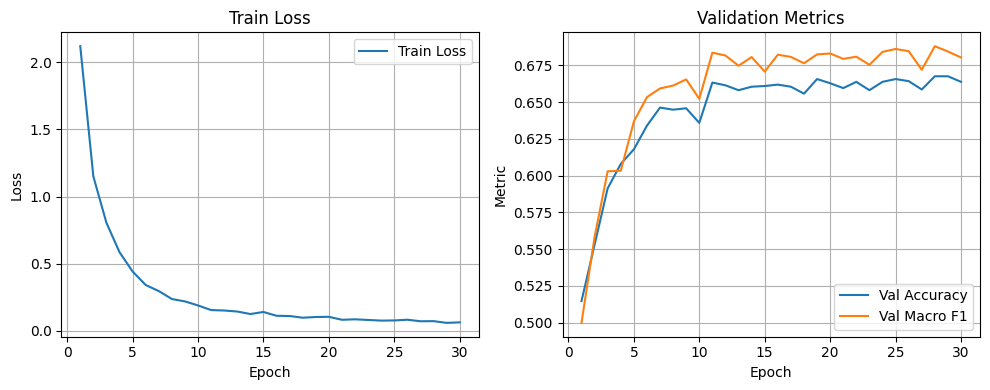

In [9]:
test_dataset = CsvImageDataset(CSV_PATH, split='test', transform=val_transform)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [15]:
def evaluate_on_domain(model, data_loader, text_tokens, class_names, seen_classes, unseen_classes, domain_name):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(DEVICE)
            text_features = model.encode_text(text_tokens)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            image_features = model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            logits = 100. * image_features @ text_features.T
            pred = logits.argmax(dim=1).cpu().numpy()
            preds.extend(pred)
            trues.extend(labels.cpu().numpy())
    acc = accuracy_score(trues, preds)
    macro_f1 = f1_score(trues, preds, average='macro')
    print(f"[{domain_name} Test] Top-1 Accuracy: {acc:.4f}, Macro F1: {macro_f1:.4f}")

    idx_to_class = {i: c for i, c in enumerate(class_names)}
    trues_cls = [idx_to_class[i] for i in trues]
    preds_cls = [idx_to_class[i] for i in preds]
    seen_acc, unseen_acc, h_mean = compute_gzsl(trues_cls, preds_cls, seen_classes, unseen_classes)
    print(f"[{domain_name} GZSL] Seen acc: {seen_acc:.4f} | Unseen acc: {unseen_acc:.4f} | H-mean: {h_mean:.4f}")
    return acc, macro_f1, seen_acc, unseen_acc, h_mean

In [ ]:
for domain in DATASET_DIRS:
    # Фильтруем по нужному домену и 'test'
    domain_df = df[(df['split'] == 'test') & (df['domain'] == domain)].reset_index(drop=True)
    if len(domain_df) == 0:
        continue
    # Создаём датасет для этого домена
    domain_dataset = CsvImageDataset(CSV_PATH, split='test', transform=val_transform)
    # Переопределяем выборку: только текущий домен
    domain_dataset.df = domain_df
    # Если класс_names/мэппинг отличается, пересоздай их:
    domain_dataset.class_names = sorted(domain_dataset.df['class_name'].unique())
    domain_dataset.class_to_idx = {cls: i for i, cls in enumerate(domain_dataset.class_names)}
    domain_loader = DataLoader(domain_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    # Для каждого домена пересчитай seen/unseen (на всякий случай)
    train_classes = set(df[df['split'] == 'train']['class_name'].unique())
    test_classes = set(domain_df['class_name'].unique())
    unseen_classes = test_classes - train_classes
    seen_classes = train_classes & test_classes

    # Промпты (пересчитай для каждого подмножества классов!)
    prompts = [f"a photo of a {c}" for c in domain_dataset.class_names]
    text_tokens = tokenizer(prompts).to(DEVICE)

    # Вызов функции
    evaluate_on_domain(
        model, domain_loader, text_tokens, domain_dataset.class_names,
        seen_classes, unseen_classes, domain
    )

[CUB_200_2011_split Test] Top-1 Accuracy: 0.5728, Macro F1: 0.5472
[CUB_200_2011_split GZSL] Seen acc: 0.0000 | Unseen acc: 0.5728 | H-mean: 0.0000
[dtd_split Test] Top-1 Accuracy: 0.4898, Macro F1: 0.4508
[dtd_split GZSL] Seen acc: 0.0000 | Unseen acc: 0.4898 | H-mean: 0.0000
[fungi_clef_2022_split Test] Top-1 Accuracy: 0.2034, Macro F1: 0.1598
[fungi_clef_2022_split GZSL] Seen acc: 0.0000 | Unseen acc: 0.2034 | H-mean: 0.0000


: 

In [1]:
import torch
import open_clip
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

# === Конфиги ===
CSV_PATH = 'merged_dataset_v2.csv'
BATCH_SIZE = 64
NUM_WORKERS = 0
NUM_EPOCHS = 100
LR = 1e-5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_NAME = 'ViT-B-32'
PRETRAINED = 'laion2b_s34b_b79k'
CHECKPOINT_PATH = 'finetuned_openclip_v1.pth'

SPLITS = ['train', 'val', 'test', 'обучение', 'валидация', 'тест']  # можно адаптировать под свой CSV

In [3]:
df = pd.read_csv(CSV_PATH)
all_classes = sorted(df['class_name'].unique().tolist())

# --- Датасеты ---
train_dataset = CsvImageDataset(CSV_PATH, split='train', transform=train_transform, class_names=all_classes)
val_dataset   = CsvImageDataset(CSV_PATH, split='val',   transform=val_transform, class_names=all_classes)

train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader    = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

idx_to_class = {i: c for i, c in enumerate(all_classes)}
class_to_idx = {c: i for i, c in enumerate(all_classes)}

# --- Seen/Unseen классы ---
train_classes = set(df[df['split'] == 'train']['class_name'].unique())
val_classes = set(df[df['split'] == 'val']['class_name'].unique())
unseen_classes = val_classes - train_classes
seen_classes = train_classes & val_classes

# --- Текстовые эмбеддинги для всех классов ---
tokenizer = open_clip.get_tokenizer(MODEL_NAME)
prompts = [f"{c}" for c in all_classes]
text_tokens = tokenizer(prompts).to(DEVICE)
with torch.no_grad():
    text_features = open_clip.create_model_and_transforms(MODEL_NAME, pretrained=PRETRAINED)[0].to(DEVICE).encode_text(text_tokens)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

# --- Модель (разморозка только visual encoder) ---
model, _, _ = open_clip.create_model_and_transforms(MODEL_NAME, pretrained=PRETRAINED)
model = model.to(DEVICE)
for p in model.parameters():
    p.requires_grad = False
for p in model.visual.parameters():
    p.requires_grad = True
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# --- Обучение и валидация ---
train_losses, val_accuracies, val_f1s = [], [], []
gzsl_seen_accs, gzsl_unseen_accs, gzsl_hmeans = [], [], []

for epoch in range(NUM_EPOCHS):
    # === Train ===
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Эпоха {epoch+1}"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        image_features = model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        logits = 100. * image_features @ text_features.T
        loss = loss_fn(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Train loss: {avg_train_loss:.4f}")

    # === Validation ===
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Валидация'):
            images = images.to(DEVICE)
            image_features = model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            logits = 100. * image_features @ text_features.T
            pred = logits.argmax(dim=1).cpu().numpy()
            preds.extend(pred)
            trues.extend(labels.cpu().numpy())

    # Имена классов для GZSL
    trues_cls = [idx_to_class[i] for i in trues]
    preds_cls = [idx_to_class[i] for i in preds]
    seen_acc, unseen_acc, h_mean = compute_gzsl(trues_cls, preds_cls, seen_classes, unseen_classes)
    print(f"[GZSL] Seen acc: {seen_acc:.4f} | Unseen acc: {unseen_acc:.4f} | H-mean: {h_mean:.4f}")
    gzsl_seen_accs.append(seen_acc)
    gzsl_unseen_accs.append(unseen_acc)
    gzsl_hmeans.append(h_mean)

    # Accuracy & F1
    acc = accuracy_score(trues, preds)
    macro_f1 = f1_score(trues, preds, average='macro')
    val_accuracies.append(acc)
    val_f1s.append(macro_f1)
    print(f"[Валидация] Top-1 Accuracy: {acc:.4f}, Macro F1: {macro_f1:.4f}")

    # Чекпоинт
    if (epoch + 1) % 10 == 0:
        checkpoint_path = f"{CHECKPOINT_PATH}_epoch{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Сохранён чекпоинт: {checkpoint_path}")

# --- Финальное сохранение ---
torch.save(model.state_dict(), CHECKPOINT_PATH)
print("Обучение завершено. Модель сохранена.")

NameError: name 'pd' is not defined